## Leaf Classification - Relatório 2

Modelos lineares/simples:

* Bayesiano (sklearn.naive_bayes)

Modelo não-linear:

* KNeighborsClassifier

Árvore:

* Decision tree

Ensemble:

* Random Forests

Redes neurais:

* Multi-layer Perceptron ([sklearn.neural_network.MLPClassifier](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised))

SVM:

* SVC ([sklearn.svm](http://scikit-learn.org/stable/modules/svm.html#svm))

# Tratando os dados

As próximas duas céclulas preparam os dados pra rodar os classificadores. No final:

* `train` tem o conjunto de treinamento
* `labels` tem as respostas pra todas as amostras do conjunto de treinamento
* `test` e `test_ids` pode ignorar, seria importante só se a gente fosse fazer submit no kaggle
* `classes` tem a lista de classes existentes no nosso problema

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [50]:
# Swiss army knife function to organize the data

def encode(train, test):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species strings
    classes = list(le.classes_)                    # save column names for submission
    test_ids = test.id                             # save test ids for submission
    
    train = train.drop(['species', 'id'], axis=1)  
    test = test.drop(['id'], axis=1)
    
    return train, labels, test, test_ids, classes

train, labels, test, test_ids, classes = encode(train, test)

# Começam os testes

Importamos um bando de coisas: (métricas de avaliação)[http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics] (primeira linha de import), métodos de classificação (linhas 2 a 7 de import) e  umas utilidades pra fazer cross-validation(última linha de import).

Aí colocamos uma pá de classificadores num array e vamos testá-los. Ali embaixo defini uma função `crossValidate` pra fazer a cross-validation e printar as coisas bonitinho, **mas antes disso** criei aquele `folds`.

`folds` é a o que a cross-validation usa pra dividir o nosso conjunto sempre nos mesmos 10 subgrupos e fazer a mesma cross-validation. Não precisa se preocupar com isso.

## Sobre as métricas:

É uma boa revermos se essas métricas fazem sentido mesmo. Do jeito que elas estão sendo feitas ele calcula a métrica (precision ou recall respectivamente) pra cada classe e faz uma média de todos os valores achados pois, como pode se ver dentro da função `crossValidate`, elas estão sendo feitas com o parâmetro `average='macro'`. Existem outros parâmetros que podemos passar pra `average`, mas não sei se faz sentido. Mostrar *precision* e *average* pra cada classe com cada classificador ia ficar muita coisa e não ia ser nada esclarecedor...

Do jeito que está `recall_score` funciona igual funcionaria `accuracy_score`.

No notebook do Kaggle, o cara usa uma métrica (`log_loss`)[http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss], mas não cheguei a ler sobre ele e por que ela seria útil. Vale ressaltar que ela não usa como entrada o resultado default de `cross_val_predict`, por isso tive que fazer:

```
train_predictions_proba = cross_val_predict(clf, train, labels, n_jobs=-1, cv=folds, method='predict_proba')
print("LogLoss: ", log_loss(labels, train_predictions_proba))
```

*(comentei porque dava problema de overflow)*

In [51]:
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_recall_fscore_support, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict

classifiers = [
    ("3 n",KNeighborsClassifier(3)),
    ("rbf",SVC(kernel="rbf", C=0.025, probability=True)),
    ("",DecisionTreeClassifier()),
    ("10 trees",RandomForestClassifier()),
    ("100 trees",RandomForestClassifier(n_estimators=100)),
    ("",GaussianNB()),
    ("",LinearDiscriminantAnalysis())
]

result_log = []

# Define a KFold for cross-validation
# Guarantees all cross validations are made with the same split
folds = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

# Cross validation
def crossValidate(classifiers, train, labels, folds):
    for s,clf in classifiers:
        name = clf.__class__.__name__
    
        print("="*30)
        print(name+" "+s)
    
        print('****Results****')
        train_predictions = cross_val_predict(clf, train, labels, n_jobs=-1, cv=folds)#clf.predict(X_test)
        train_predictions_proba = cross_val_predict(clf, train, labels, n_jobs=-1, cv=folds, method='predict_proba')
        prec = precision_score(labels, train_predictions, average='macro')
        rec = recall_score(labels, train_predictions, average='macro')
        ll = log_loss(labels, train_predictions_proba)
        result_log.append([name+" "+s, prec, rec, ll])
        print("Precision: ", prec)
        print("Recall: ", rec)
        print("LogLoss: ", ll)
    
    print("="*30)
    
# Test for classifiers above
crossValidate(classifiers, train, labels, folds)

KNeighborsClassifier 3 n
****Results****
Precision:  0.898580375853
Recall:  0.891919191919
LogLoss:  1.66908706585
SVC rbf
****Results****
Precision:  0.815300943805
Recall:  0.80101010101
LogLoss:  4.60008521
DecisionTreeClassifier 
****Results****
Precision:  0.697049471292
Recall:  0.687878787879
LogLoss:  10.7802847536
RandomForestClassifier 10 trees
****Results****
Precision:  0.90722052919
Recall:  0.89797979798
LogLoss:  1.18350788254
RandomForestClassifier 100 trees
****Results****
Precision:  0.976382511989
Recall:  0.974747474747
LogLoss:  0.716329720821
GaussianNB 
****Results****
Precision:  0.750538610202
Recall:  0.611111111111
LogLoss:  13.4045550904
LinearDiscriminantAnalysis 
****Results****


/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder

Precision:  0.980466671376
Recall:  0.977777777778
LogLoss:  1.01430161414


# Testes com redes neurais

A partir daqui testo com redes neurais (MultiLayer Perceptron)[http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.predict].

Primeiro pra 1 camada com os tamanhos 1, 99 e 198

In [4]:
MLPs = [
    ("(1)", MLPClassifier(hidden_layer_sizes=(1,))),
    ("(99)", MLPClassifier(hidden_layer_sizes=(99,))),
    ("(198)", MLPClassifier(hidden_layer_sizes=(198,)))
]

crossValidate(MLPs, train, labels, folds)

MLPClassifier
****Results****
Precision:  0.000877698763534
Recall:  0.0111111111111
MLPClassifier
****Results****
Precision:  0.911367448489
Recall:  0.9
MLPClassifier
****Results****
Precision:  0.936460649339
Recall:  0.929292929293


# Padronizando os dados

Aí eu li que padronizando seria melhor pq o MLP é sensível à escala. Usei esse StandardScaler do sklearn que padroniza automático e rodei de novo pra doi métodos lá de cima (que nos meus testes foram os únicos que se mostraram sensíveis à escala) e pras redes neurais de novo

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)

crossValidate(classifiers[:2]+MLPs, scaler.transform(train), labels, folds)

KNeighborsClassifier
****Results****
Precision:  0.976946622401
Recall:  0.973737373737
SVC
****Results****
Precision:  0.98034423489
Recall:  0.977777777778
MLPClassifier
****Results****
Precision:  0.00517677797802
Recall:  0.0242424242424
MLPClassifier
****Results****
Precision:  0.98406285073
Recall:  0.982828282828
MLPClassifier
****Results****
Precision:  0.989868380777
Recall:  0.988888888889


In [38]:
MLPs = [
    ("(99,99)", MLPClassifier(hidden_layer_sizes=(99,99)))
]

crossValidate(MLPs, scaler.transform(train), labels, folds)

MLPClassifier
****Results****
Precision:  0.981058447725
Recall:  0.978787878788


In [39]:
MLPs = [
    ("(300, 300)", MLPClassifier(hidden_layer_sizes=(300,300)))
]

crossValidate(MLPs, scaler.transform(train), labels, folds)

MLPClassifier
****Results****
Precision:  0.985246403428
Recall:  0.983838383838


In [40]:
MLPs = [
    ("(500, 500)", MLPClassifier(hidden_layer_sizes=(500,500)))
]

crossValidate(MLPs, scaler.transform(train), labels, folds)

MLPClassifier
****Results****
Precision:  0.985899398021
Recall:  0.984848484848


MLPClassifier
****Results****
Precision:  0.00517677797802
Recall:  0.0242424242424
MLPClassifier
****Results****
Precision:  0.0432902739459
Recall:  0.0767676767677
MLPClassifier
****Results****
Precision:  0.336751433089
Recall:  0.338383838384
MLPClassifier
****Results****
Precision:  0.80601396359
Recall:  0.80202020202
MLPClassifier
****Results****
Precision:  0.952892561983
Recall:  0.949494949495
MLPClassifier
****Results****
Precision:  0.975512702785
Recall:  0.972727272727
MLPClassifier
****Results****
Precision:  0.98326701357
Recall:  0.981818181818
MLPClassifier
****Results****
Precision:  0.988674625038
Recall:  0.986868686869
MLPClassifier
****Results****
Precision:  0.987848178757
Recall:  0.986868686869
MLPClassifier
****Results****
Precision:  0.989929599021
Recall:  0.988888888889
MLPClassifier
****Results****
Precision:  0.988950107132
Recall:  0.987878787879
MLPClassifier
****Results****
Precision:  0.989868380777
Recall:  0.988888888889
MLPClassifier
****Results*

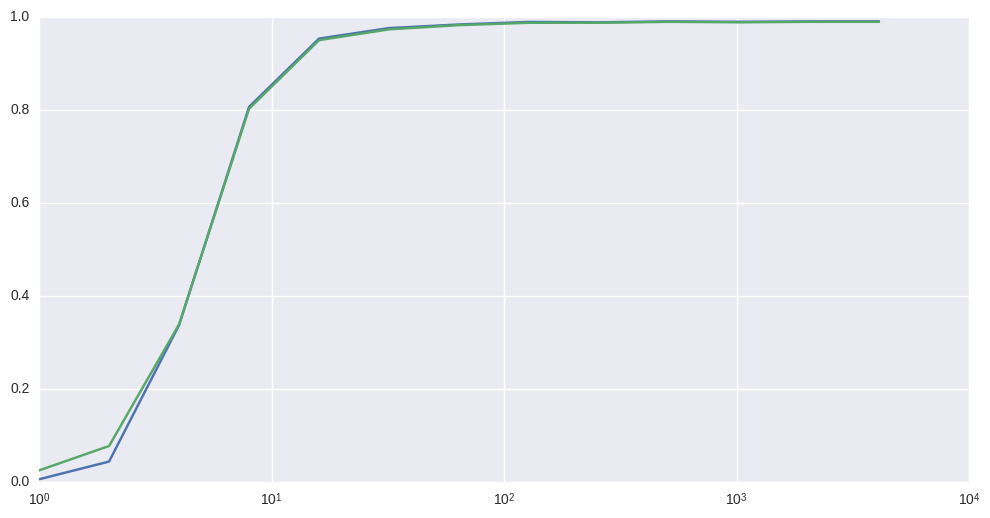

In [48]:
MLP_sizes = [(N,MLPClassifier(hidden_layer_sizes=(N,))) for N in (1.4)**np.arange(30)]

def crossValidatePlot(classifiers, train, labels, folds):
    ns = []
    precs = []
    recs = []
    for n,clf in classifiers:
        name = clf.__class__.__name__
        ns.append(n)
    
        print("="*30)
        print(name)
    
        print('****Results****')
        train_predictions = cross_val_predict(clf, train, labels, n_jobs=-1, cv=folds)
        prec = precision_score(labels, train_predictions, average='macro')
        rec = recall_score(labels, train_predictions, average='macro')
        precs.append(prec)
        recs.append(rec)
        print("Precision: ", precision_score(labels, train_predictions, average='macro'))
        print("Recall: ", recall_score(labels, train_predictions, average='macro'))
        
        #train_predictions_proba = cross_val_predict(clf, train, labels, n_jobs=-1, cv=folds, method='predict_proba')
        #print("LogLoss: ", log_loss(labels, train_predictions_proba))
    
    print("="*30)
    plt.figure(figsize=(12,6))
    plt.semilogx(ns,precs)
    plt.semilogx(ns,recs)
    plt.show()
    
    return precs, recs

ggp, ggr = crossValidatePlot(MLP_sizes, scaler.transform(train), labels, folds)

# Ainda temos que:

* Fazer a matriz de distâncias ordenando por classe (faltou do relatorio 1)
* definir quais metricas de distância vamos user e porque
* fazer uns gráficos pra os valores das métricas pros classificadores
* testar novas topologias de rede neural (mais camadas, distribuir de jeitos diferentes)
* se der tempo: usar (algum método de otimização de hiperparâmetros)[http://scikit-learn.org/stable/modules/grid_search.html] pra fazer uma rede neural melhor
* ler sobre os classificadores que usamos
* avaliar os resultados

In [32]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.figure(figsize=(12,12))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, cm[i, j],
                 #horizontalalignment="center",
                 #color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(12,12))
    plt.show()
    #plt.figure(figsize=(12,12))

In [18]:
train_predictions = cross_val_predict(MLPClassifier(hidden_layer_sizes=(198,)), train, labels, n_jobs=-1, cv=folds)


Confusion matrix, without normalization
[[10  0  0 ...,  0  0  0]
 [ 0 10  0 ...,  0  0  0]
 [ 0  0 10 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 10  0  0]
 [ 0  0  0 ...,  0 10  0]
 [ 0  0  0 ...,  0  0  8]]


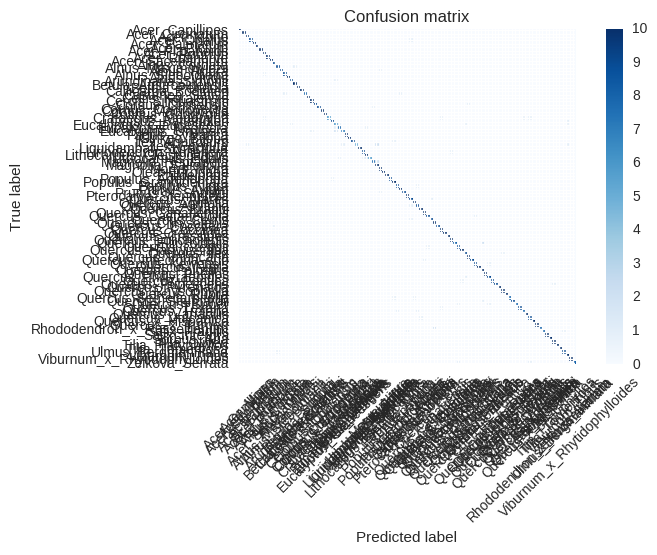

In [35]:
cnf_matrix = confusion_matrix(labels, train_predictions)  
plot_confusion_matrix(cnf_matrix, classes)   